# DecMeg2014 - Decoding the Human Brain

### Documentación

Repositorio de Kaggle: 
 https://www.kaggle.com/c/decoding-the-human-brain

Repositorio de Github (Ejemplos de códigos en Matlab y Python):
https://github.com/FBK-NILab/DecMeg2014

### Importación de librerías

In [33]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from scipy.io import loadmat
import seaborn as sns
import matplotlib.pyplot as plt

## Red LSTM
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

### Coger los datos de los archivos .mat

#### Preprocesamiento: Coger primeros 500ms de datos y normalizarlos

Creamos una función "create_features" que se encargará de devolver los valores X. En esta función, se realiza todo el procesamiento de los datos. Los preprocesamiento que realiza son:

    1. Paso de la lista X de 3D a 2D. Poniendo como filas el primer elemento (las diferentes pruebas) y como columnas se hace un join del segundo elemento(series temporales o canales) y del tercer elemento(valores de cada serie temporal)
    
    2. Cogemos una ventana de valores
    
    3. Normalizamos los valores restandolos por la media y dividiéndolo por la desviación típica

In [14]:
def create_features(XX, tmin, tmax, sfreq, tmin_original=-0.5):
    """Creation of the feature space:
    - restricting the time window of MEG data to [tmin, tmax]sec.
    - Concatenating the 306 timeseries of each trial in one long
      vector.
    - Normalizing each feature independently (z-scoring).
    """
    """print("Applying the desired time window.")
    beginning = np.round((tmin - tmin_original) * sfreq).astype(np.int)
    end = np.round((tmax - tmin_original) * sfreq).astype(np.int)
    XX = XX[:, :, beginning:end].copy()"""

    #print("2D Reshaping: concatenating all 306 timeseries.")
    #XX = XX.reshape(XX.shape[0], XX.shape[1] * XX.shape[2])

    print("Features Normalization.")
    XX -= XX.mean(0)
    XX = np.nan_to_num(XX / XX.std(0))

    return XX

#### Coger todos los .mat en un array aplicando el preprocesado

Cogemos los datos de los ficheros train_subject13.mat, del 13 al 16. En esta etapa se realizan varios pasos:

    1. Creamos una lista X_train y y_train que contendrán todos los datos para realizar el entrenamiento. 
    
    2. Por cada uno de los ficheros, llamamos a la función create_features para que realice el correspondiente preprocesamiento de los datos.
    
    3. Una vez tenemos los datos del fichero, los agregamos a la lista.
    
    4. Una vez tenemos todas las listas en la lista, creamos un array realizando un join de las listas dentro de la lista. Para eso utilizamos la función vstack de la librería numpy

In [ ]:
subjects_train = range(1, 17) # use range(13, 16) for all subjects
print("Training on subjects", subjects_train )

# We throw away all the MEG data outside the first 0.5sec from when
# the visual stimulus start:
tmin = 0.0
tmax = 0.500
print("Restricting MEG data to the interval [%s, %s]sec." % (tmin, tmax))

X_train = []
y_train = []
X_test = []
ids_test = []

print("Creating the trainset.")
for subject in subjects_train:
    filename = './data/data/train_subject%02d.mat' % subject
    print("Loading", filename)
    data = loadmat(filename, squeeze_me=True)
    XX = data['X']
    yy = data['y']
    sfreq = data['sfreq']
    tmin_original = data['tmin']
    print("Dataset summary:")
    print("XX:", XX.shape)
    print("yy:", yy.shape)
    print("sfreq:", sfreq)

    XX = create_features(XX, tmin, tmax, sfreq)
    
    print("XX (Preprocessed): ", XX.shape)

    X_train.append(XX)
    y_train.append(yy)
    
X_train = np.vstack(X_train)
y_train = np.concatenate(y_train)
print("Trainset:", X_train.shape)

Training on subjects range(1, 17)
Restricting MEG data to the interval [0.0, 0.5]sec.
Creating the trainset.
Loading ./data/data/train_subject01.mat
Dataset summary:
XX: (594, 306, 375)
yy: (594,)
sfreq: 250.0
Features Normalization.
XX (Preprocessed):  (594, 306, 375)
Loading ./data/data/train_subject02.mat
Dataset summary:
XX: (586, 306, 375)
yy: (586,)
sfreq: 250.0
Features Normalization.
XX (Preprocessed):  (586, 306, 375)
Loading ./data/data/train_subject03.mat
Dataset summary:
XX: (578, 306, 375)
yy: (578,)
sfreq: 250.0
Features Normalization.
XX (Preprocessed):  (578, 306, 375)
Loading ./data/data/train_subject04.mat
Dataset summary:
XX: (594, 306, 375)
yy: (594,)
sfreq: 250.0
Features Normalization.
XX (Preprocessed):  (594, 306, 375)
Loading ./data/data/train_subject05.mat
Dataset summary:
XX: (586, 306, 375)
yy: (586,)
sfreq: 250.0
Features Normalization.
XX (Preprocessed):  (586, 306, 375)
Loading ./data/data/train_subject06.mat
Dataset summary:
XX: (588, 306, 375)
yy: (588,

### Separación de archivos train/test

In [28]:
X_train_new, X_test, y_train_new, y_test = train_test_split(X_train,y_train,test_size=0.2)
print("X_train_new: ",X_train_new.shape)
print("y_train_new: ",y_train_new.shape)
print("X_test: ",X_test.shape)
print("y_test: ",y_test.shape)
print(y_test)

X_train_new:  (1876, 306, 375)
y_train_new:  (1876,)
X_test:  (470, 306, 375)
y_test:  (470,)
[0 0 1 0 0 1 0 1 1 1 0 0 1 0 1 1 0 0 0 1 1 0 0 0 1 0 1 1 1 0 1 1 0 1 1 1 0
 0 0 1 1 1 1 0 1 0 1 1 1 0 0 0 1 1 1 1 0 0 0 0 0 1 0 0 1 1 1 1 1 0 1 1 1 0
 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0
 1 0 1 0 1 1 1 0 0 0 0 0 0 1 0 0 1 1 1 0 0 1 0 1 0 1 1 0 0 1 1 1 1 1 0 1 1
 0 0 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 1 1 0 1 1 0 1 1 1 0 1 1 1 0 0 1 1 0 1 0
 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 1 1 0 1 0 0 0 1 0 0 1 0 0 0 1 0 1 1 1 1
 1 0 0 0 1 1 1 1 0 0 0 0 0 0 0 1 1 0 1 1 0 0 1 0 0 1 0 0 0 1 1 1 0 1 1 1 1
 1 1 0 0 1 1 1 1 1 0 1 0 0 0 1 1 1 1 1 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 1 1 1
 1 0 1 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 1 0 1 1 1 0 0 1 1 0
 1 0 0 1 0 1 1 1 1 0 0 0 1 0 0 0 0 1 0 0 1 1 0 0 0 1 0 1 1 0 0 0 0 1 1 1 1
 1 1 1 0 0 1 0 1 0 1 0 0 1 0 0 1 0 1 0 0 0 1 1 1 0 0 0 1 0 0 0 1 1 1 1 1 0
 0 1 1 1 0 1 0 1 1 1 1 1 1 0 1 1 0 0 0 1 1 0 1 1 1 0 0 0 1 1 1 1 0 1 1 0 0
 1 1 1

### Red LSTM

#### Creación de la red

In [25]:
# Creación de la red
model = Sequential()
model.add(LSTM(3, input_shape=(306, 375)))
model.add(Dense(1, activation='sigmoid'))
model.summary()

# Compilación de la red
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Entrenamiento de la red
model.fit(X_train_new,y_train_new, validation_data=(X_test,y_test), epochs=7, batch_size=10)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 3)                 4548      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 4         
Total params: 4,552
Trainable params: 4,552
Non-trainable params: 0
_________________________________________________________________
Train on 1876 samples, validate on 470 samples
Epoch 1/7
1876/1876 [==============================] - 27s 15ms/step - loss: 0.6957 - acc: 0.5117 - val_loss: 0.6910 - val_acc: 0.5234
Epoch 2/7
1876/1876 [==============================] - 31s 16ms/step - loss: 0.6697 - acc: 0.6050 - val_loss: 0.6926 - val_acc: 0.5191
Epoch 3/7
1876/1876 [==============================] - 33s 17ms/step - loss: 0.6492 - acc: 0.6487 - val_loss: 0.6962 - val_acc: 0.5277
Epoch 4/7
1876/1876 [==============================] - 31s 17ms/step - loss: 0.6254 

#### Predicciones

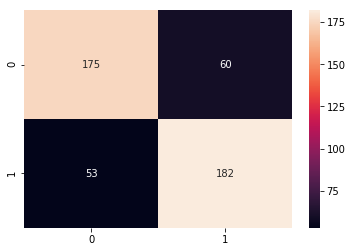

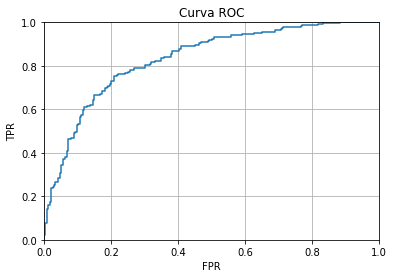

In [36]:
def convert(x):
    result = []
    for i in range(len(x)):
        if x[i] < 0.5:
            result.append(0)
        else:
            result.append(1)
    return result
# Predecimos a partir de los datos de test
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)
y_pred = convert(y_pred)
#print(y_proba)

fprs,tprs,thresholds = metrics.roc_curve(y_test,y_proba)

# Evaluación
sns.heatmap(metrics.confusion_matrix(y_test,y_pred),annot=True, fmt="d")
plt.show()

plt.plot(fprs, tprs)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title("Curva ROC")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.grid(True)
plt.show()

### Correlacion entre sensores

#### Creación del dataframe de correlación y gráfica de mapa de colores

Número de sensores:  306


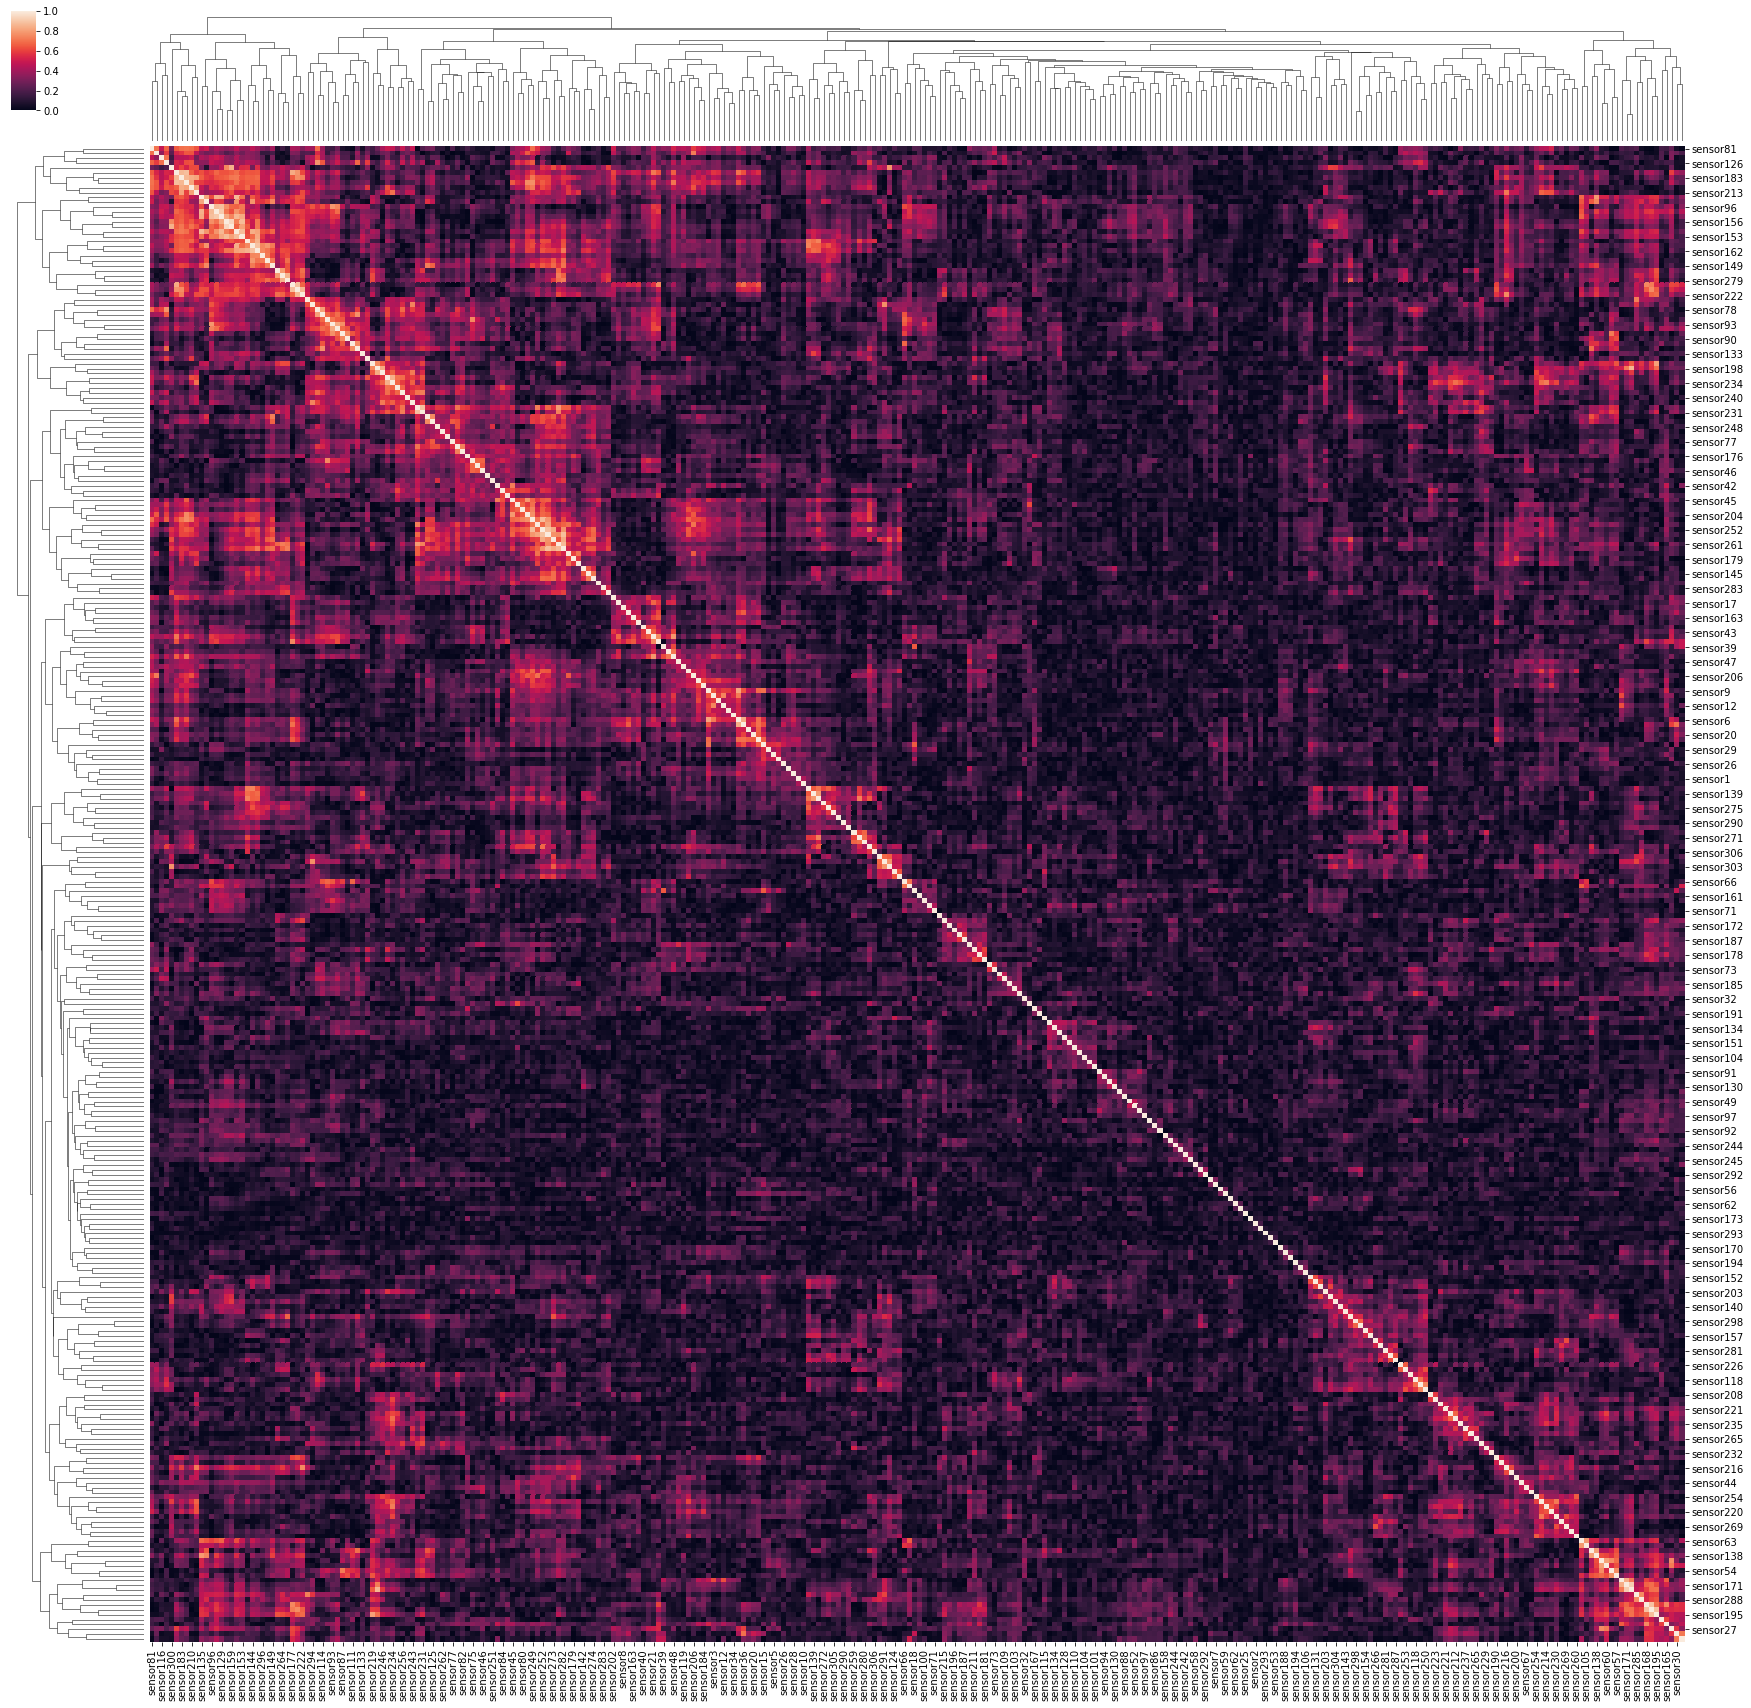

In [14]:
dataframe_sensores = pd.DataFrame()
num_sensores = int(len(X_train[0,:])/375)
print("Número de sensores: ",num_sensores)
columns = []
for i in range(1,num_sensores+1):
    nameSensor = 'sensor%s' % i 
    columns.append(nameSensor)
    dataframe_sensores[nameSensor] = pd.Series(X_train[0,(i-1)*375:i*375])
#print(dataframe_sensores)

correlaciones = dataframe_sensores.corr()

#sns.heatmap(correlaciones)

sns.clustermap(correlaciones.abs(),figsize=(30, 30))

#### Lista de correlaciones más altas

In [16]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute correlaciones de sensores")
print(get_top_abs_correlations(dataframe_sensores,100))

Top Absolute correlaciones de sensores
sensor156  sensor159    0.948390
sensor171  sensor189    0.918332
sensor99   sensor129    0.912803
sensor144  sensor162    0.892087
sensor168  sensor192    0.891823
sensor228  sensor231    0.887680
sensor252  sensor255    0.887434
sensor96   sensor129    0.886019
sensor192  sensor195    0.884277
sensor177  sensor186    0.883931
sensor180  sensor201    0.882869
sensor249  sensor252    0.882265
sensor255  sensor282    0.880506
sensor132  sensor153    0.878370
sensor261  sensor282    0.873498
sensor132  sensor135    0.873424
sensor153  sensor156    0.872684
sensor96   sensor99     0.868648
sensor180  sensor183    0.865800
sensor186  sensor222    0.865018
sensor129  sensor132    0.863769
sensor183  sensor201    0.863723
sensor189  sensor198    0.862931
sensor162  sensor297    0.852275
sensor264  sensor279    0.851842
sensor225  sensor234    0.850291
sensor99   sensor135    0.849612
sensor159  sensor300    0.847713
sensor132  sensor144    0.842068
sens

#### Eliminación de sensores con mayor correlación

### Visualización de los datos

In [11]:
print(X_train.shape)
first_probe = X_train[0,:]
print(first_probe)
senors_values = []
for i in range(1,306):
    

(588, 38250)
[-1.8112224  -1.0874811  -0.18253571 ... -0.02355056  0.02517387
  0.09659942]


In [12]:
print(dataframe)
#sns.distplot(dataframe.iloc[0:100,0:375],kde=True,hist=True)

        0         1         2         3         4         5         6      \
0   -1.811222 -1.087481 -0.182536 -0.466642 -1.105666 -0.972519 -2.179797   
1   -0.680744 -0.542822 -0.578040  0.530787  0.271257 -0.706857 -1.821322   
2   -0.519984 -0.911802  0.202178  0.126008 -0.554339 -0.910988 -1.346741   
3   -0.711059  0.986628  0.665046 -0.811154 -0.626254 -0.379954 -0.749373   
4   -0.949496 -0.373295 -1.284967 -0.534028  0.959178  0.264727  2.180007   
5   -0.181002 -0.862479  0.570032  1.072724  0.489955 -0.082830  1.174180   
6    2.492688  1.151223  0.563009  1.893177  0.973079  0.798032 -0.575617   
7    0.854221  0.419142  1.067379  0.542577  0.884601  1.502928  1.355720   
8   -0.738382 -0.908667  0.036003  0.001355 -0.937850 -0.439793  0.979969   
9   -0.058762 -0.738514  0.342903  0.388052 -0.352417 -0.584514  0.084709   
10  -0.729575 -1.194956  0.374196 -0.141888  0.939628  1.310000 -0.323790   
11   2.020984  2.459413  1.487146  0.341238  0.632361  1.410035  0.889798   